### Imports

In [ ]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
import os

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Optimisation
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score

# Machine LearninG
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import log_loss

# Evaluation
# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

# Reporting
import matplotlib.pyplot as plt


### Import Preprocessed Data

In [ ]:
# Construct the file path
file_path = os.path.join('Data Augmented', 'XAU_USD_M15_AUGMENTED_MULTICLASS.pkl')

# Load the dataset
df = pd.read_pickle(file_path)

In [ ]:
# Assuming the last column is the target variable and the rest are features
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Now, let's perform some checks to ensure it worked
print("Shape of entire DataFrame: ", df.shape)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check the first few records to ensure the split looks correct
print("\nFirst 5 rows of features (X):")
print(X.head())
print("\nFirst 5 rows of target (y):")
print(y.head())

# Check the types to confirm they are pandas DataFrames/Series
print("\nType of X: ", type(X))
print("Type of y: ", type(y))


Shape of entire DataFrame:  (23562, 27)
Shape of X:  (23562, 26)
Shape of y:  (23562,)

First 5 rows of features (X):
       PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
0 -6.254425  2.829216 -4.891684 -2.845976  4.008486 -8.555140  5.862690   
1 -3.850872  4.903726 -1.756492 -5.537689  2.208127 -4.524315  3.431820   
2 -1.095318  5.893986 -0.804774 -5.597807  2.819885 -6.055102  5.503417   
3  2.351989  7.265397  1.256356 -5.356025  4.113341 -6.214222  3.473383   
4  0.294494  5.522330 -1.981066 -4.531020  2.242955 -5.241408  3.138588   

        PC_7      PC_8      PC_9  ...     PC_16     PC_17      PC_18  \
0   7.165960  3.078656  3.506201  ...  3.422188 -2.717913 -14.004499   
1  11.216646 -0.391129  3.273041  ...  2.816306 -1.706859 -10.416053   
2   9.982037  1.918705  5.091947  ...  3.110125 -3.930625  -6.267588   
3   9.101391  0.924793  5.216997  ...  2.856252 -0.231934 -13.271259   
4  10.148424  0.734575  5.403931  ...  3.014510 -1.393204 -10.976878   

### Train Test Split

In [ ]:
# Assuming X and y are your features and labels respectively and they are already ordered sequentially
dataset_size = len(X)
train_size = int(dataset_size * 0.7)  # 70% of data for training

# Split the dataset into training set and test set without shuffling
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [ ]:
size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (16493, 26)
Shape of y_train:  (16493,)
Shape of X_test:  (7069, 26)
Shape of y_test:  (7069,)
Size Matches:  True


### Build Initial Model

In [ ]:

space = {
    'max_depth': hp.choice('max_depth', range(3, 15, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.3),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.3),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'objective': 'multi:softmax',
    'num_class': 3
}

In [ ]:
from sklearn.model_selection import cross_validate

def objective(space):

    classifier_0 = XGBClassifier(**space)
    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    accuracy_scores = cross_validate(classifier_0, X_train, y_train, scoring='accuracy', cv=tscv)

    return {'loss': -np.mean(accuracy_scores['test_score']), 'status': STATUS_OK}

# Initialize trials object
trials = Trials()

# Define your space variable here, as it's not provided in the original snippet

# Run the hyperparameter search using the tpe algorithm
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=50,
                        trials=trials)

print("The best hyperparameters are:", best_hyperparams)


100%|██████████████████████████████████████████████████████| 50/50 [42:41<00:00, 51.23s/trial, best loss: -0.8114992721979621]
The best hyperparameters are: {'colsample_bytree': 0.7012626211318509, 'gamma': 0.18491071141285537, 'learning_rate': 0.15328063590185478, 'max_depth': 0, 'min_child_weight': 4.0, 'n_estimators': 6, 'reg_alpha': 0.2603758573177602, 'reg_lambda': 0.10969731591700628, 'subsample': 0.5692755190587262}


### Train Model

In [ ]:

# Use space_eval to get the actual hyperparameters from the best indices returned by fmin
actual_best_params = space_eval(space, best_hyperparams)
# Build Classification Model 1 with the best hyperparameters
classifier_1 = XGBClassifier(**actual_best_params, random_state=42)

In [ ]:


# Fit the model using the training set and evaluate it using the validation set
classifier_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7012626211318509, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.18491071141285537,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15328063590185478,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

### Make Predictions

In [ ]:
# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, classifier_1.predict(X_train))
test_accuracy = accuracy_score(y_test, classifier_1.predict(X_test))

In [ ]:
# Calculate precision scores
precision_scores_train = precision_score(y_train, classifier_1.predict(X_train), average=None)
precision_scores_test = precision_score(y_test, classifier_1.predict(X_test), average=None)

In [ ]:
# Output the results
print("TRAIN:")
print("Accuracy:", train_accuracy)
print("Precision Scores:", precision_scores_train)

print("TEST:")
print("Accuracy:", test_accuracy)
print("Precision Scores:", precision_scores_test)

TRAIN:
Accuracy: 0.9507669920572364
Precision Scores: [0.92469001 0.9652333  0.96230159]
TEST:
Accuracy: 0.8274154760220682
Precision Scores: [0.71299094 0.88589685 0.9058296 ]


EVAL COMPAR

In [ ]:
# Make predictions on the test set
y_pred = classifier_1.predict(X_test)

In [ ]:
# Calculate the classification report
report = classification_report(y_test, y_pred)


In [ ]:
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      2340
           1       0.89      0.84      0.86      2314
           2       0.91      0.84      0.87      2415

    accuracy                           0.83      7069
   macro avg       0.83      0.83      0.83      7069
weighted avg       0.84      0.83      0.83      7069



SUMMARY

In [ ]:
confusion matrix

SyntaxError: invalid syntax (1435892540.py, line 1)

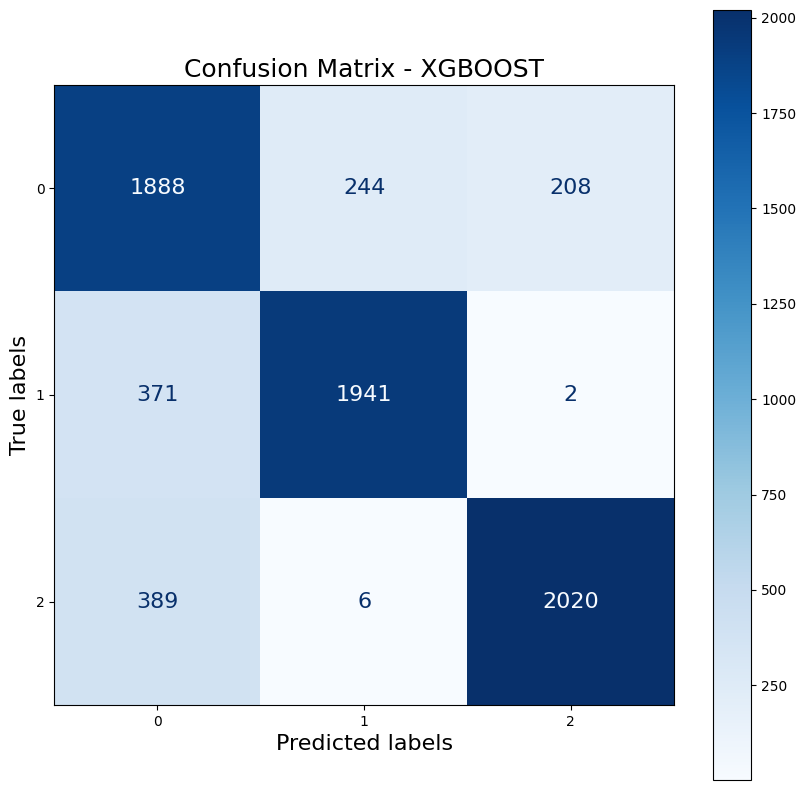

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size for better visibility
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Blues')

# Scale up the labels and title
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18

ax.set_xlabel('Predicted labels', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('True labels', fontsize=LABEL_FONT_SIZE)
ax.set_title('Confusion Matrix - XGBOOST', fontsize=TITLE_FONT_SIZE)

# Scale up the numbers inside the confusion matrix
for text in ax.texts:
    text.set_fontsize(LABEL_FONT_SIZE)

plt.show()

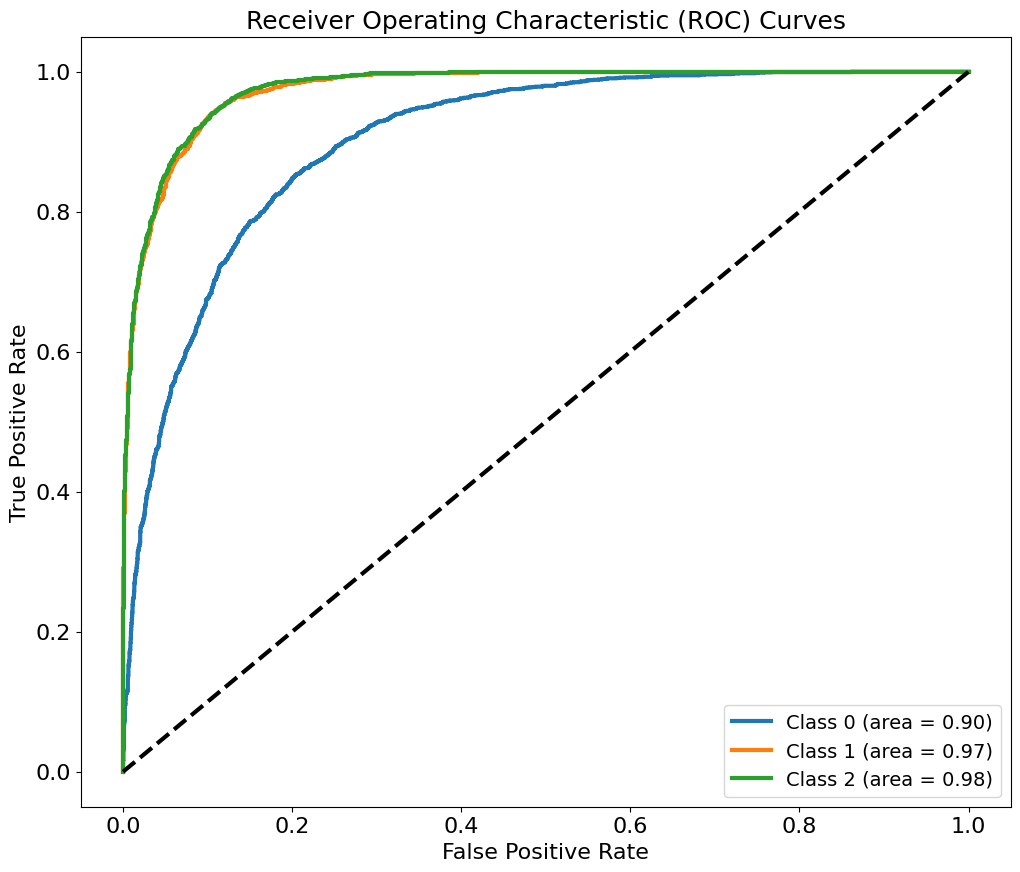

Micro-average AUC: 0.96


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba = classifier_1.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set the figure size and plot the ROC curves with scaled up features
plt.figure(figsize=(12, 10))

# Set larger font sizes and line widths
LINE_WIDTH = 3
FONT_SIZE = 16
LEGEND_SIZE = 14

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linewidth=LINE_WIDTH, label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=LINE_WIDTH)

# Set the labels and title with increased font sizes
plt.xlabel('False Positive Rate', fontsize=FONT_SIZE)
plt.ylabel('True Positive Rate', fontsize=FONT_SIZE)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=FONT_SIZE + 2)

# Set the tick parameters for axes
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

# Set the legend with an increased font size
plt.legend(loc="lower right", fontsize=LEGEND_SIZE)

# Show the plot with adjusted settings
plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f'Micro-average AUC: {roc_auc["micro"]:.2f}')

In [ ]:
# Assuming test_yhat is your NumPy array
df_signal = pd.DataFrame(test_yhat, columns=['signal'])

In [ ]:
# Save the DataFrame to a CSV file
df_signal.to_csv('signal_multiclass.csv', index=False)